In [5]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from ipywidgets import interact

import pandas as pd
import scipy.stats as stats
import pymc as pm
import seaborn as sns
import arviz as az

Populating the interactive namespace from numpy and matplotlib


# Question 1

During your internship at EPCOR, you are given a dataset containing 10,000 observations of monthly utility bills (in Canadian dollars) for Edmonton houses over the last couple of years. Along with the monthly bill, you are also given:

- `avg_temperature`: the average temperature during the billing month (in Celsius).
- `household_size`: the number of people living in the house during the billing month.
- `house_taxes`: the yearly property taxes according to the last tax notice (in Canadian dollars).

Under the consent of residents, the City of Edmonton kindly provided household and taxes information for the dataset. This information was matched, but it's not perfect.

Your goal is to determine whether the utility bill amount can be predicted using the other three variables.

## A (15 points)

Load the data from the file `EPCOR1.csv` (link provided below) into a Pandas DataFrame. Clean the data by removing any corrupted values.

Do you think using mean imputation is a better approach to deal with corrupted observations in this case? Explain.

In [6]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/Epcor1.csv'
data = pd.read_csv(path_to_data)
data

,avg_temperature,household_size,house_taxes,bill
0,21.083807,4,2341.40,339.825365
1,17.945661,2,4061.82,317.335924
2,10.818872,1,2616.26,304.327370
3,26.491015,1,4835.50,316.291108
4,0.811429,3,5853.50,308.869530
...,...,...,...,...
9995,9.195303,1,5629.54,295.463720
9996,-5.014737,2,4041.46,308.811366
9997,9.263699,3,3634.26,300.816582
9998,3.120226,2,3786.96,299.321222


In [7]:
data.describe()

,avg_temperature,household_size,house_taxes,bill
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.261718,2.098500,4107.637598,310.312478
std,8.226165,1.175388,6314.119179,13.754624
min,-25.774117,0.000000,682.060000,287.571982
25%,-1.410821,1.000000,2718.060000,300.194427
50%,4.249438,2.000000,3613.900000,307.332263
75%,9.875206,3.000000,4519.920000,317.376281
max,38.480774,8.000000,99999.000000,446.639790


In [8]:
house_taxes = 'house_taxes'
data.loc[data[house_taxes]  == 99999,  house_taxes] = pd.NA
data.dropna(inplace=True)
data_cleaned = data.copy()
data_cleaned

,avg_temperature,household_size,house_taxes,bill
0,21.083807,4,2341.40,339.825365
1,17.945661,2,4061.82,317.335924
2,10.818872,1,2616.26,304.327370
3,26.491015,1,4835.50,316.291108
4,0.811429,3,5853.50,308.869530
...,...,...,...,...
9995,9.195303,1,5629.54,295.463720
9996,-5.014737,2,4041.46,308.811366
9997,9.263699,3,3634.26,300.816582
9998,3.120226,2,3786.96,299.321222


Here I think use mean imputation is not a good idea to deal the corrupted observations. The outlier in this dataset is 99999 on house_taxes. This value is so high that it makes us underestimate the impact of house_taxes on bill. Relatively speaking, there are only about 50 extreme values ​​here, and deleting them will have a small impact on the overall data. Therefore, it is better to delete them here.

## B (10 points)

Create scatter plots for the utility bill versus the average temperature and the property taxes in different subplots within the same figure.

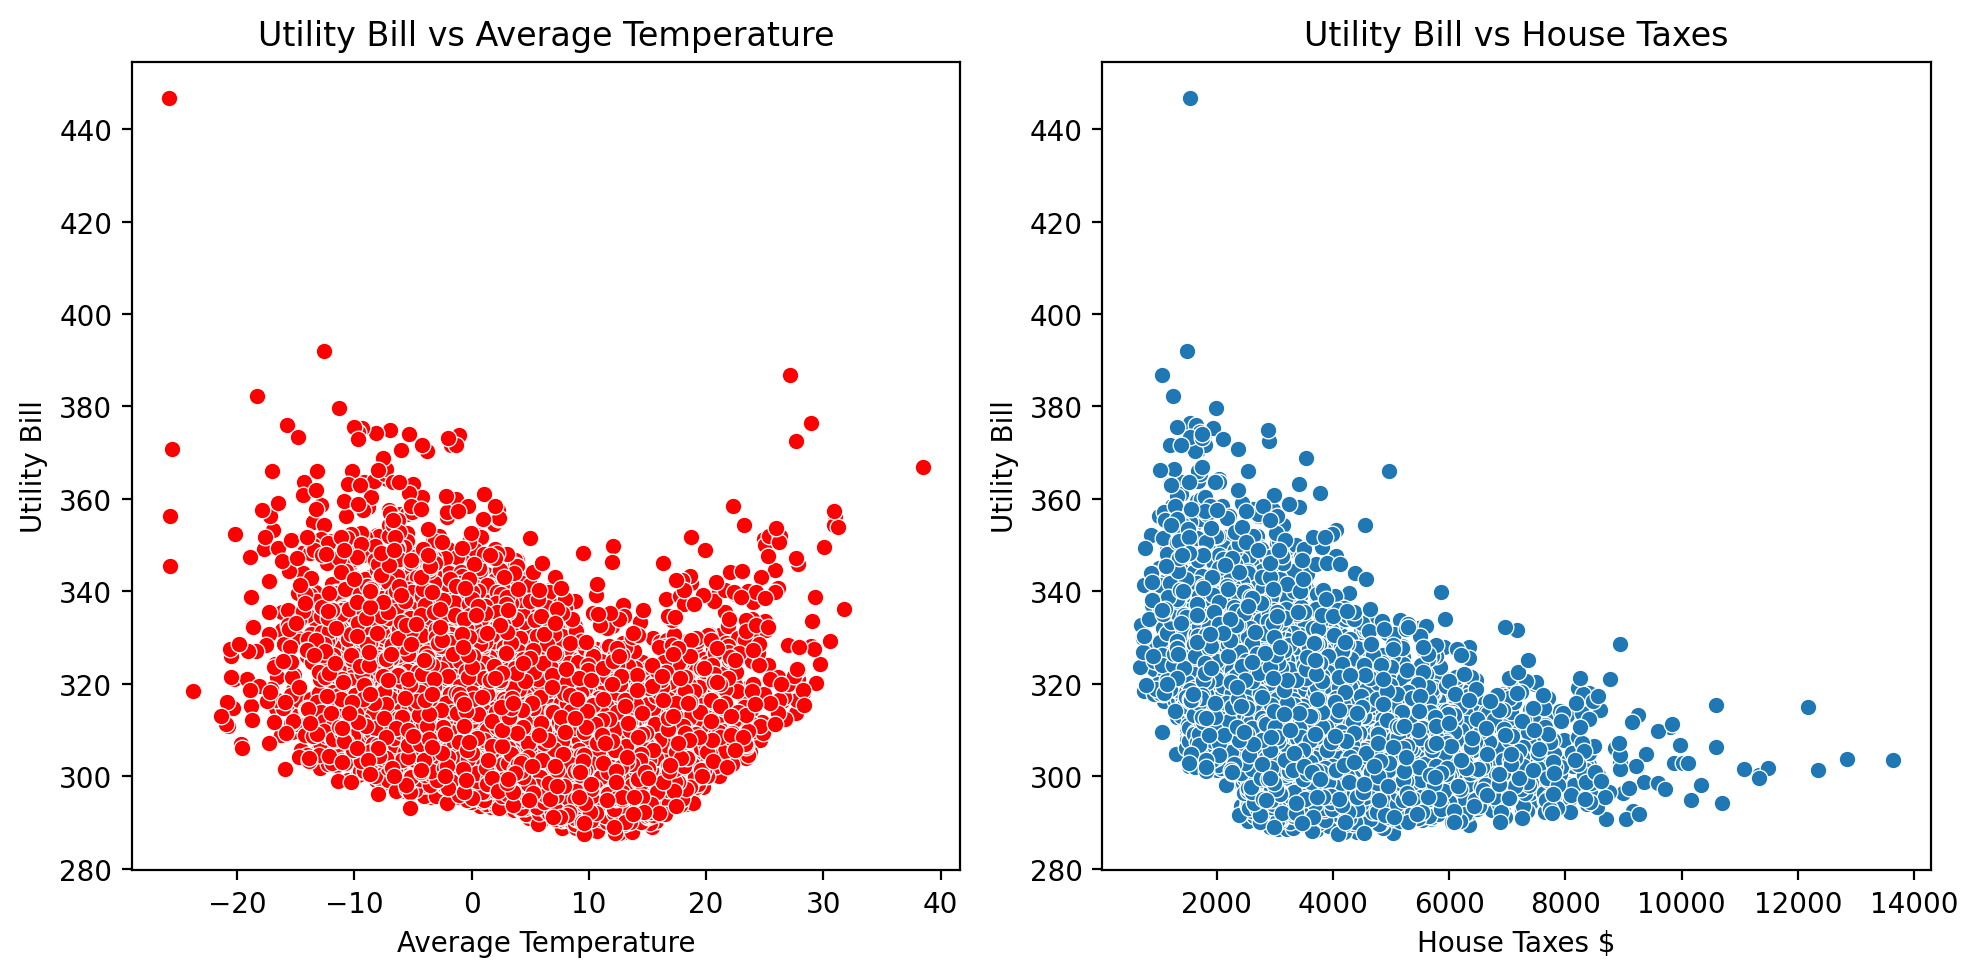

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=data_cleaned, x='avg_temperature', y='bill', ax=axs[0], color = 'red')
axs[0].set_xlabel('Average Temperature')
axs[0].set_ylabel('Utility Bill')
axs[0].set_title('Utility Bill vs Average Temperature')

sns.scatterplot(data=data_cleaned, x='house_taxes', y='bill', ax=axs[1])
axs[1].set_xlabel('House Taxes $')
axs[1].set_ylabel('Utility Bill')
axs[1].set_title('Utility Bill vs House Taxes')

plt.tight_layout()
plt.show()

## C (10 points)

Preprocess the data by standardizing all predictor variables.

In [10]:
from sklearn.preprocessing import StandardScaler

predictors = ['avg_temperature', 'household_size', 'house_taxes']\

scaler = StandardScaler()
data[predictors] = scaler.fit_transform(data[predictors])
data

,avg_temperature,household_size,house_taxes,bill
0,2.045122,1.617561,-0.965665,339.825365
1,1.663565,-0.083705,0.245704,317.335924
2,0.797042,-0.934339,-0.772133,304.327370
3,2.702567,-0.934339,0.790461,316.291108
4,-0.419730,0.766928,1.507248,308.869530
...,...,...,...,...
9995,0.599638,-0.934339,1.349555,295.463720
9996,-1.128115,-0.083705,0.231368,308.811366
9997,0.607954,0.766928,-0.055346,300.816582
9998,-0.139011,-0.083705,0.052172,299.321222


In [11]:
data.describe()

,avg_temperature,household_size,house_taxes,bill
count,9.959000e+03,9.959000e+03,9.959000e+03,9959.000000
mean,2.140404e-17,-1.648111e-16,-4.394963e-16,310.319256
std,1.000050e+00,1.000050e+00,1.000050e+00,13.762937
min,-3.652180e+00,-1.784972e+00,-2.134026e+00,287.571982
25%,-6.900462e-01,-9.343386e-01,-7.076218e-01,300.196727
50%,-1.492260e-03,-8.370526e-02,-7.684993e-02,307.358428
75%,6.825997e-01,7.669281e-01,5.539219e-01,317.376375
max,4.160362e+00,5.020095e+00,6.990662e+00,446.639790


## D (25 points)

Propose prior distributions for a simple linear model for `bill` using `avg_temperature` and `household_size` as predictors. Create prior predictive plots. Use MCMC sampling (make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 20 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distributions.

We assume the following model:
$
bill_i \sim \text{Normal}(\mu_i, \sigma)
$

$
\mu_i = \beta_0 + \beta_1 \cdot avg\_temperature + \beta_2 \cdot household\_size
$

$
\beta_0 \sim \text{Normal}(310, 20)
$

$
\beta_1 \sim \text{Normal}(0, 10)
$

$
\beta_2 \sim \text{Normal}(0, 10)
$

$
\sigma \sim \text{Exponential}(0, 1)
$

My choice of prior distributions is reasonable based on the dataset. I set $ \beta_0 \sim N(310, 20) $ because the mean of bill is 310.32, and a standard deviation of 20 provides enough flexibility while keeping the estimate centered around observed values.

For $ \beta_1 \sim \mathcal{N}(0, 10) $ and $ \beta_2 \sim N(0, 10) $, I chose these priors because both avg_temperature and household_size are standardized (mean 0, standard deviation 1), meaning the coefficients can have a reasonable range of influence without being overly constrained. Given that avg_temperature ranges from -3.65 to 4.16 and household_size from -1.78 to 5.02, these priors allow enough variation while maintaining numerical stability.

For the error term, I set $ \sigma \sim Exponential(0,1) $ because it ensures a positive standard deviation while favoring smaller values, which is suitable given that the standard deviation of bill is 13.76. The exponential prior strongly discourages large values of $ \sigma $, assuming that the residual variance is relatively small. If I find that the residual variance is underestimated, I may consider adjusting the prior to allow more flexibility.

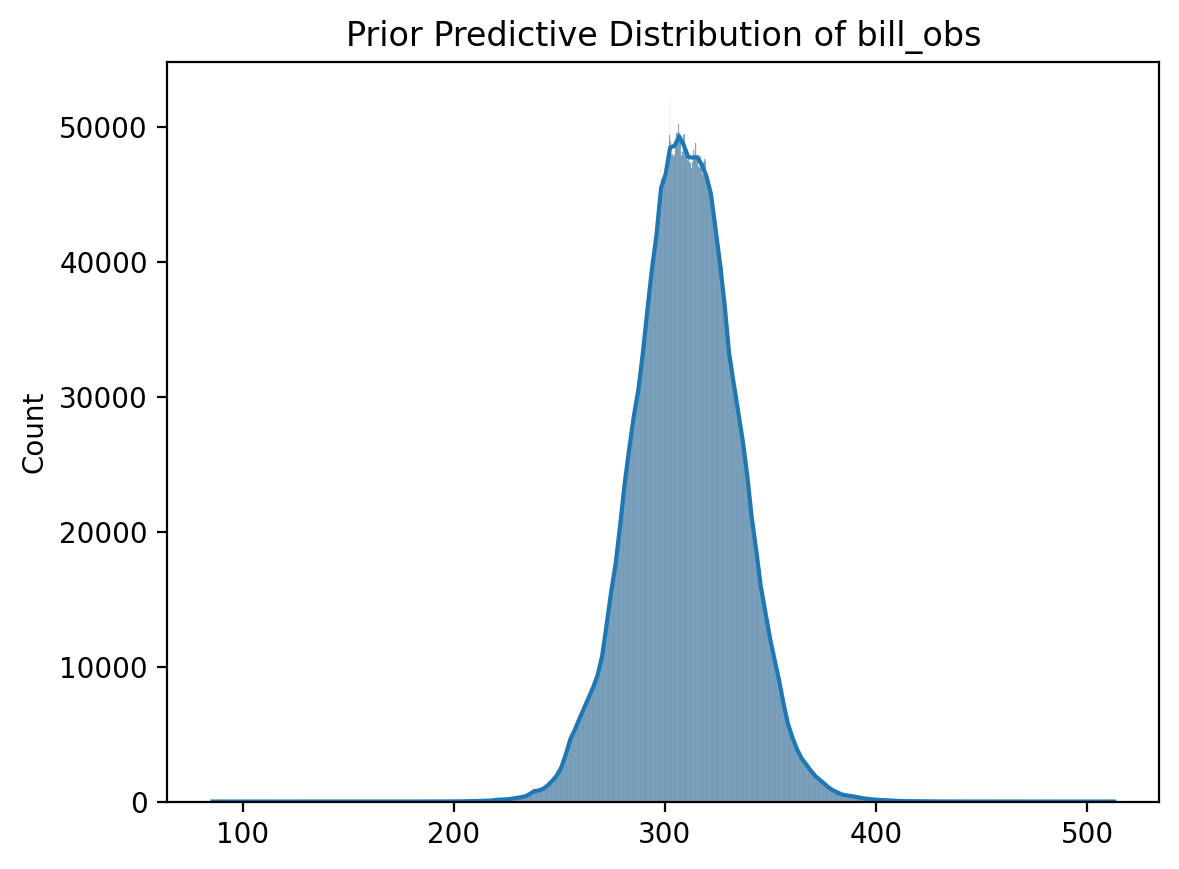

Output()

In [18]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=310, sigma=20)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)
    _mu = beta_0 + beta_1 *data['avg_temperature'] + beta_2 *data['household_size']
    mu = pm.Deterministic('mu', _mu)

    bill_obs = pm.Normal("bill_obs", mu=mu, sigma=sigma, observed=data['bill'])
    prior_predictive = pm.sample_prior_predictive(samples=1000, var_names=["bill_obs"])
    sns.histplot(prior_predictive.prior_predictive["bill_obs"].values.flatten(), kde=True)
    plt.title("Prior Predictive Distribution of bill_obs")
    plt.show()

    _trace = pm.sample(1000, tune=1000, chains=4, return_inferencedata=True)

trace = _trace.posterior.to_dataframe()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,310.317,0.119,310.092,310.538,0.001,0.001,7503.0,2758.0,1.0
beta_1,-4.529,0.119,-4.748,-4.307,0.001,0.001,7424.0,3806.0,1.0
beta_2,4.978,0.122,4.751,5.195,0.001,0.001,6543.0,3210.0,1.0
sigma,11.979,0.085,11.817,12.132,0.001,0.001,6173.0,2935.0,1.0


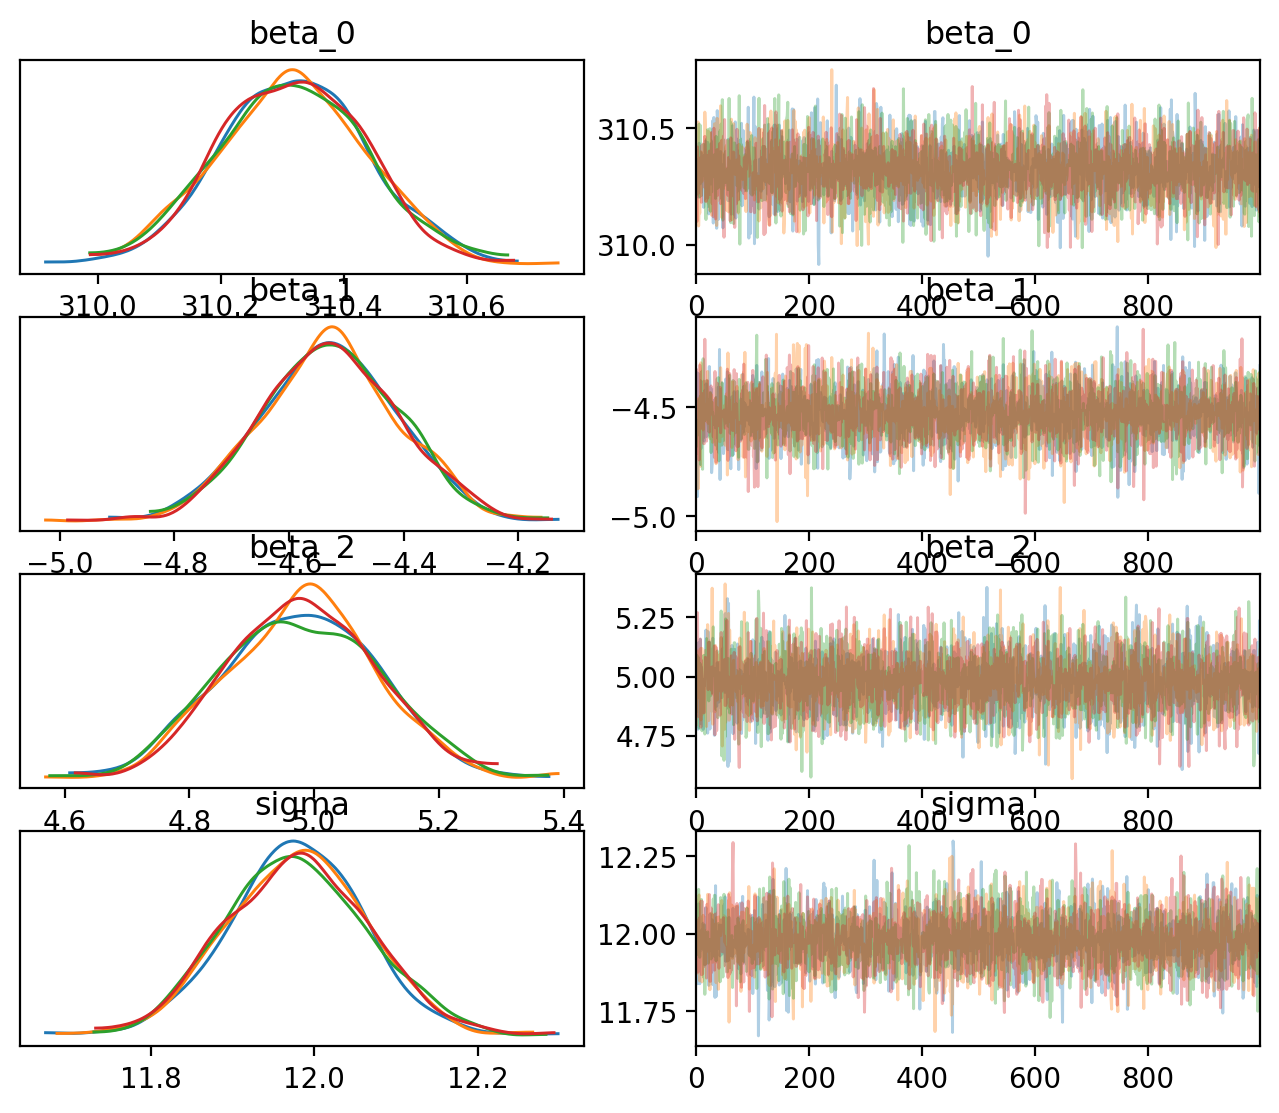

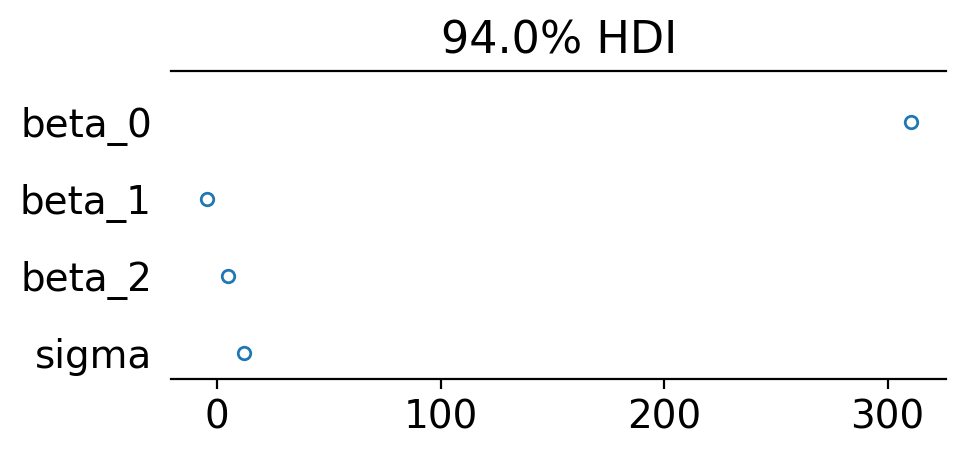

In [13]:
varnames = ['beta_0', 'beta_1', 'beta_2', 'sigma']
display(pm.summary(_trace, var_names=varnames))
az.plot_trace(_trace, varnames, compact=False, figsize=(8, 1.6*len(varnames)));
az.plot_forest(_trace, var_names=["~mu"], combined=True, figsize=[5, 2]);

## E (10 points)

Based on the scatter plot obtained in part B, do you think this is a reasonable model? Interpret the mean of the posterior for each of the parameters. Comment on the relationship between the monthly average temperature and the utility bill amount. How would you approach modeling the utility bill as a function of the average monthly temperature?

Based on the scatter plots obtained in part B, I think the relationship between avg_temperature and bill appears to be nonlinear, since the higher bills appear for both extreme low temp and high temp. This suggests that temperature may have a quadratic or discrete relationship with bills. The house_taxes variable has a decreasing relationship with bills, but not as strong as the temperature.

From the posterior summaries in part D, the estimated mean for $\beta_1$
 is around -4.529, indicating that increase in standardized avg_temperature is associated with a decrease in utility bills. Similarly, $\beta_2$
 is estimated at 4.979, suggesting that larger household sizes contribute to higher bills.The posterior mean for $\beta_0$
 is around 310, which aligns well with the mean of bill, and $\sigma$
 is estimated at 11.98, indicating the amount of residual variation not explained by the predictors.

Given the scatter plot pattern and the posterior estimates, a simple linear model may not fully capture the relationship between avg_temperature and bill. A more appropriate approach would be to introduce a quadratic term (i.e., avg_temperature²) to account for the nonlinear trend. Alternatively, using discrete regression or spline regression can help better model the potential impact of seasonality on utility bills. Another approach is to include interaction terms, such as the interaction between avg_temperature and house_size, to capture any combined effects of climate and household behavior on energy consumption.

## F (20 points)

Extend the linear model by adding `house_taxes` as a predictor. Use MCMC sampling (again, make 4 chains with 1000 samples and 1000 warm-up steps) to estimate the posterior probability (it should take less than 25 seconds). Display a summary and plot all posterior distributions.

Justify your choice of prior distribution.

We assume the following model:
$
bill_i \sim \text{Normal}(\mu_i, \sigma)
$

$
\mu_i = \beta_0 + \beta_1 \cdot avg\_temperature + \beta_2 \cdot household\_size
$

$
\beta_0 \sim \text{Normal}(310, 20)
$

$
\beta_1 \sim \text{Normal}(0, 10)
$

$
\beta_2 \sim \text{Normal}(0, 10)
$

$
\beta_3 \sim \text{Normal}(0, 10)
$


$
\sigma \sim \text{Exponential}(0, 1)
$

As with the previous choice of $\beta_1$ , $\beta_2$ , the goal is to allow the coefficients $\beta_3$ to have a reasonable range of influence.


In [14]:
data

,avg_temperature,household_size,house_taxes,bill
0,2.045122,1.617561,-0.965665,339.825365
1,1.663565,-0.083705,0.245704,317.335924
2,0.797042,-0.934339,-0.772133,304.327370
3,2.702567,-0.934339,0.790461,316.291108
4,-0.419730,0.766928,1.507248,308.869530
...,...,...,...,...
9995,0.599638,-0.934339,1.349555,295.463720
9996,-1.128115,-0.083705,0.231368,308.811366
9997,0.607954,0.766928,-0.055346,300.816582
9998,-0.139011,-0.083705,0.052172,299.321222


In [15]:
with pm.Model() as model_1:
    beta_0 = pm.Normal("beta_0", mu=310, sigma=20)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)
    beta_3 = pm.Normal("beta_3", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)
    _mu = beta_0 + beta_1 *data['avg_temperature'] + beta_2 *data['household_size']+beta_3*data['house_taxes']

    mu = pm.Deterministic('mu', _mu)
    bill_obs = pm.Normal("bill_obs", mu=mu, sigma=sigma, observed=data['bill'])

    _trace1 = pm.sample(1000, tune=1000, chains=4, return_inferencedata=True)
trace1=_trace1.posterior.to_dataframe()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,310.319,0.102,310.128,310.509,0.001,0.001,6885.0,3036.0,1.0
beta_1,-4.475,0.102,-4.660,-4.280,0.001,0.001,6174.0,3474.0,1.0
beta_2,5.069,0.105,4.873,5.267,0.001,0.001,5762.0,3253.0,1.0
beta_3,-6.400,0.103,-6.592,-6.208,0.001,0.001,7171.0,3208.0,1.0
sigma,10.129,0.072,9.998,10.271,0.001,0.001,5669.0,3302.0,1.0


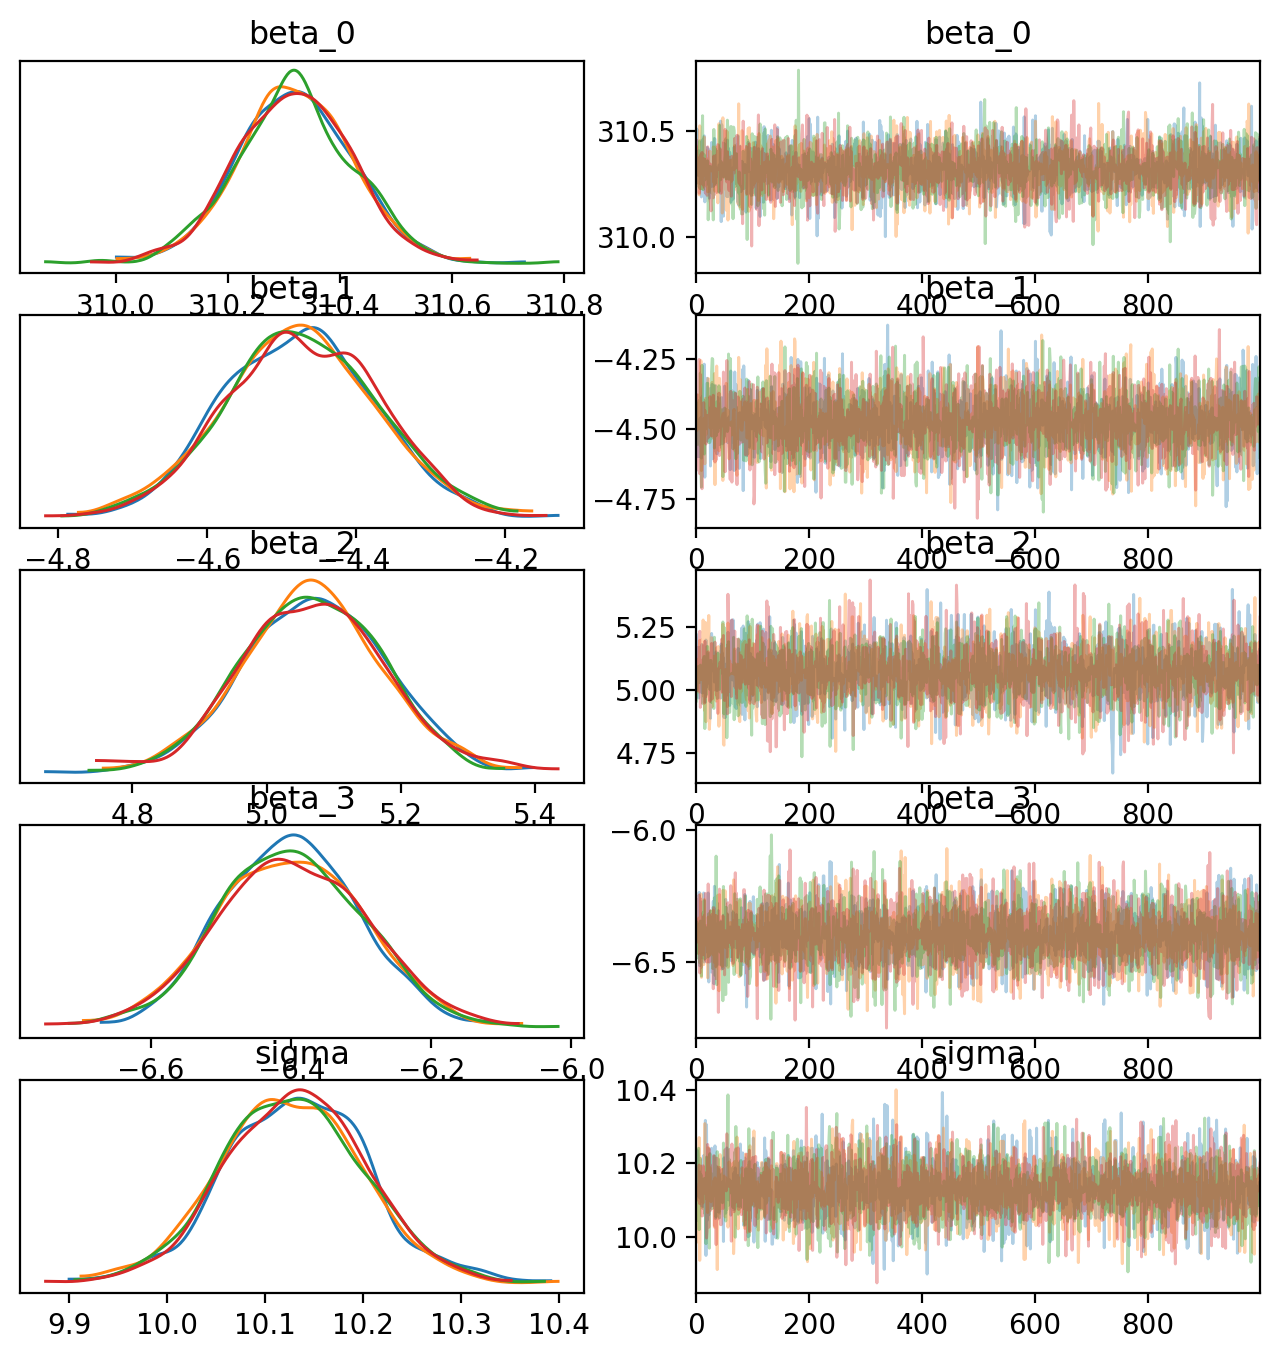

In [16]:
varnames = ['beta_0', 'beta_1', 'beta_2', 'beta_3','sigma']
display(pm.summary(_trace1, var_names=varnames))
az.plot_trace(_trace1, varnames, compact=False, figsize=(8, 1.6*len(varnames)));

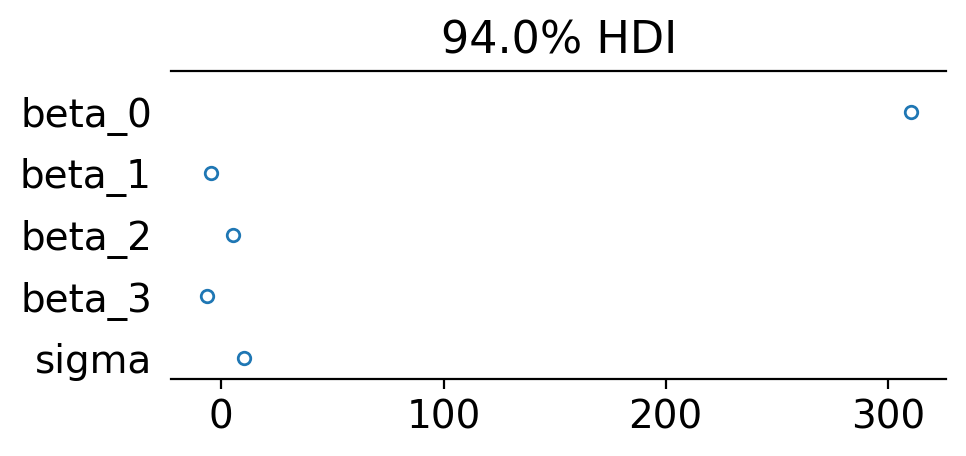

In [17]:
az.plot_forest(_trace1, var_names=["~mu"], combined=True, figsize=[5, 2]);

## G (10 points)

Interpret the mean of the posterior for the new parameter. Compare the other mean posterior values with those obtained in part E. Based on the scatter plot you obtained in part B, do you think this is a reasonable model? Comment on the relationship between the yearly property taxes and the utility bill amount. What do you think is happening here?

## Interpretation of the New Parameter

The newly added parameter $\beta_3 $ (associated with house_taxes) has a posterior mean of -6.398, which suggests that an increase in standardized house_taxes is correlated with a decrease in bill. This negative correlation is somewhat unexpected. We usually think that higher property taxes are associated with larger homes, which in turn might lead to higher utility bills.

## Comparison with Part E

Compared to the posterior values obtained in part E:
- $ \beta_0 $ remains around 310, confirming the intercept’s stability.
- $ \beta_1 $ is still negative (-4.476), reinforcing that higher average temperatures tend to lower utility bills.
- $ \beta_2 $ remains positive (5.068), meaning larger household sizes correlate with increased utility usage.
- $ \sigma $is slightly lower than in part E (10.126 instead of 11.98), indicating a slight reduction in unexplained variability due to the inclusion of house_taxes.

## Model Reasonableness

From the scatter plot in Part B, the relationship between avg_temperature and bill is nonlinear, while the relationship between house_taxes and bill shows a slight downward trend. Therefore, the negative coefficient of $ \beta_3 $ is consistent with the scatter plot but may not fully show the underlying relationship. The error greater than 10 that still exists is evidence of this. The model may benefit from nonlinear transformations or additional interaction terms to better represent the data.

## Relationship Between Property Taxes and Utility Bills

The negative relationship between house_taxes and bill could be due to several reasons:
1. Better insulation: Homes with higher property taxes may be newer and better insulated, leading to lower utility bills.
2. Using energy-saving solutions: Larger homes tend to have more space for energy-saving features like solar panels, geothermal heating, etc.

## Conclusion

While adding house_taxes to the model improves the fit slightly as shown by the decrease in $ \sigma $, the negative coefficient suggests that there is only an indirect relationship. To improve the model, I would consider exploring interaction effects or categorizing house_taxes into different ranges to capture possible threshold effects.